This notebook analyzes customer churn based on the Telco customer churn dataset. 

## What is customer churn?

Customers churn when they terminate services with a company. In the context of Telco, customers _churn_ when they stop using Telephone/TV services provided. Reasons for churn:
- They simply no longer use their services
- They go to Telco's competitors

Let us define a main problem that any financial company faces: Customer churn. They want to know exactly "Who is Churning"? 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import mannwhitneyu, ttest_ind

In [4]:
data = pd.read_csv('../data/cust_churn.csv')
data.head(n=5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We define some functions which will perform the crux of the Hypothesis testing in this notebook. More explanation in the Appendix Section 9.

In [5]:
def is_normal(group):
    """Check if input ndarray is normally distributed using the Shapiro Wilk Test"""
    wval, pval = stats.shapiro(group)
    if len(group) > 5000: # W-stat is more accurate for larger sample sizes
        if wval < 0.05: return False
    if pval < 0.05: return False
    return True

def has_eq_var(group_1, group_2):
    """Check the property of homoscendacity (equal variance) using the Levene test"""
    _, pval = stats.levene(group_1, group_2) 
    if pval < 0.05: return False
    return True

def stat_test(group_1, group_2):
    """Between 2 groups, if the conditions of normality + homoscendacity hold, perform 
    T-Test, otherwise perform the Mann Whiteny U Test."""
    if is_normal(group_1) and is_normal(group_2):
        if has_eq_var(group_1, group_2): 
            print("Performing T-Test ...")
            return stats.ttest_ind(group_1, group_2)
        print("Performing T-Test with unequal variance ...")
        return stats.ttest_ind(group_1, group_2, equal_var=False)
    print("Performing U-Test ...")
    return mannwhitneyu(group_1, group_2)

# 1 Active Vs Churned Stats

Let's get some ball park numbers to get a feel for the data. We assume the data is _all_ customer data ever.

In [6]:
# Active users are those who haven't churned
active_users = data[data['Churn'] == 'No']
churned_users = data[data['Churn'] == 'Yes']

active_internet_users = active_users[active_users['InternetService'] != 'No']
churned_internet_users = churned_users[churned_users['InternetService'] != 'No']

active_phone_users = active_users[active_users['PhoneService'] != 'No']
churned_phone_users = churned_users[churned_users['PhoneService'] != 'No']

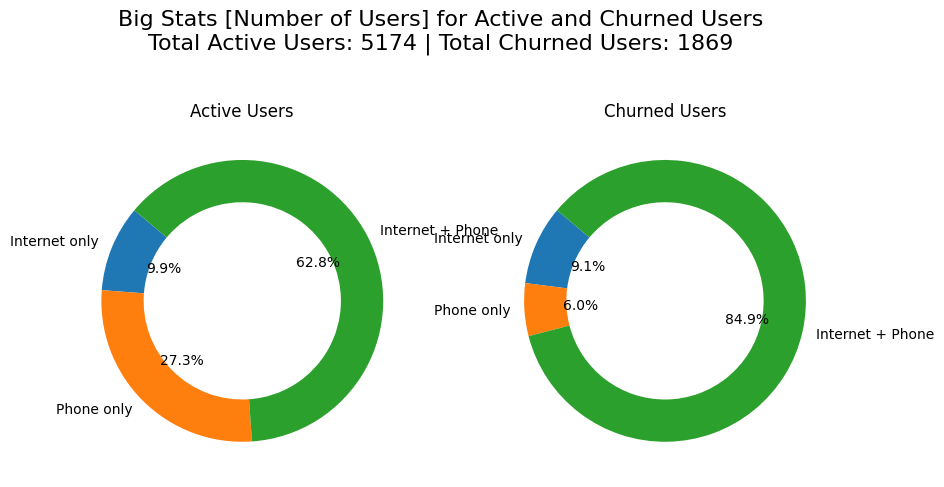

In [7]:
# Define the data for active and churned users
labels_active = ['Internet only', 'Phone only', 'Internet + Phone']
values_active = [
    active_internet_users[active_internet_users['PhoneService'] == 'No'].shape[0],
    active_phone_users[active_phone_users['InternetService'] == 'No'].shape[0],
    active_internet_users[active_internet_users['PhoneService'] != 'No'].shape[0]
]
total_active = sum(values_active)

labels_churned = ['Internet only', 'Phone only', 'Internet + Phone']
values_churned = [
    churned_internet_users[churned_internet_users['PhoneService'] == 'No'].shape[0],
    churned_phone_users[churned_phone_users['InternetService'] == 'No'].shape[0],
    churned_internet_users[churned_internet_users['PhoneService'] != 'No'].shape[0]
]
total_churned = sum(values_churned)

# Create subplots for the pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Active users pie chart
ax1.pie(values_active, labels=labels_active, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
ax1.set_title('Active Users')

# Churned users pie chart
ax2.pie(values_churned, labels=labels_churned, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
ax2.set_title('Churned Users')

# Display the total counts
fig.suptitle(f'Big Stats [Number of Users] for Active and Churned Users\nTotal Active Users: {total_active} | Total Churned Users: {total_churned}', fontsize=16)
plt.show()

**Observations**: Aside from the raw numbers
- Whether we consider Internet, Phone, or both, we have currently many more active users than churned users.
- Just because 85% of the users who churned had both internet + phone doesn’t mean the combo “internet + phone” is bad. They constitute 63% of our active user base after all. 
- Similarly, 6% churned user had only phone services doesn’t mean the "phone only" policy is good. They don’t have as many active users to begin with.

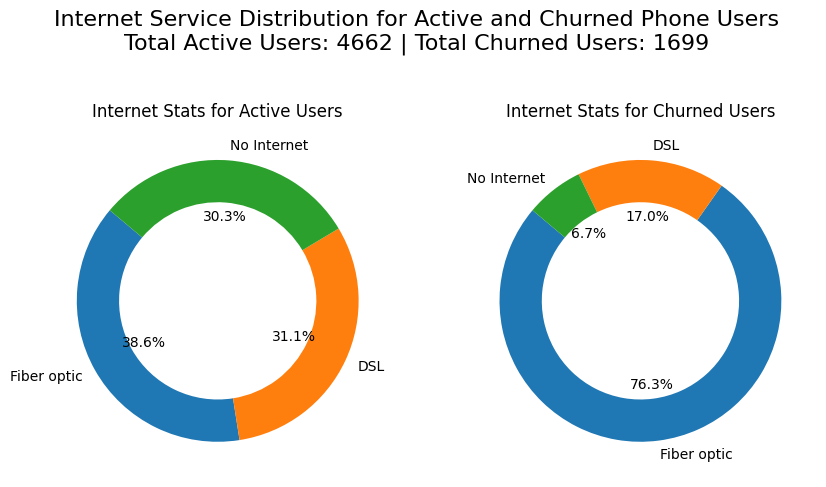

In [8]:
# Active user data
labels_active = ['Fiber optic', 'DSL', 'No Internet']
values_active = [
    active_phone_users[active_phone_users['InternetService'] == 'Fiber optic'].shape[0],
    active_phone_users[active_phone_users['InternetService'] == 'DSL'].shape[0],
    active_phone_users[active_phone_users['InternetService'] == 'No'].shape[0]
]

# Churned user data
labels_churned = ['Fiber optic', 'DSL', 'No Internet']
values_churned = [
    churned_phone_users[churned_phone_users['InternetService'] == 'Fiber optic'].shape[0],
    churned_phone_users[churned_phone_users['InternetService'] == 'DSL'].shape[0],
    churned_phone_users[churned_phone_users['InternetService'] == 'No'].shape[0]
]

# Create subplots for side-by-side pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Active users pie chart
ax1.pie(values_active, labels=labels_active, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
ax1.set_title('Internet Stats for Active Users')

# Churned users pie chart
ax2.pie(values_churned, labels=labels_churned, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
ax2.set_title('Internet Stats for Churned Users')

# Display total counts
total_active = sum(values_active)
total_churned = sum(values_churned)

# Display the plot
plt.suptitle(f'Internet Service Distribution for Active and Churned Phone Users\nTotal Active Users: {total_active} | Total Churned Users: {total_churned}', fontsize=16)
plt.show()

**Observations**:
- 76% of our churned Phone users had a Fiber Optic internet service
- Over 30% of our current phone users have no internet plan. 

# 1.2 Internet Users (Active Vs Churned)

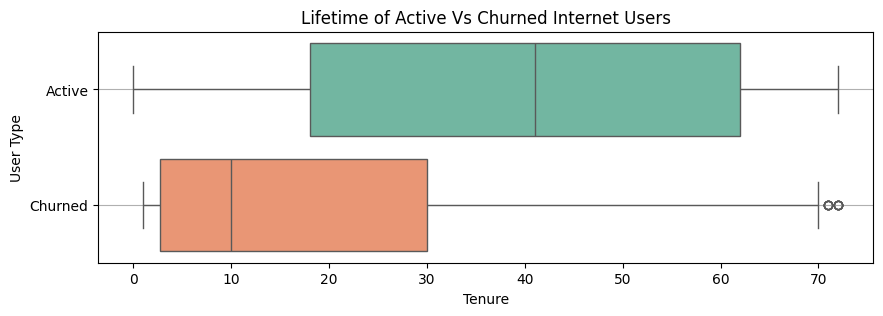

In [9]:
data = pd.DataFrame({
    'Active': active_internet_users['tenure'],
    'Churned': churned_internet_users['tenure']
})

# Create the box plot without melting the DataFrame
plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Active Vs Churned Internet Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [10]:
group_1 = active_internet_users['tenure']
group_2 = churned_internet_users['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(4978462.0), pvalue=np.float64(2.0596236201332951e-203))

**Observation**: Current active internet users have stay with us much longer than churned users

## 1.3 Phone Users (Active Vs Churned)

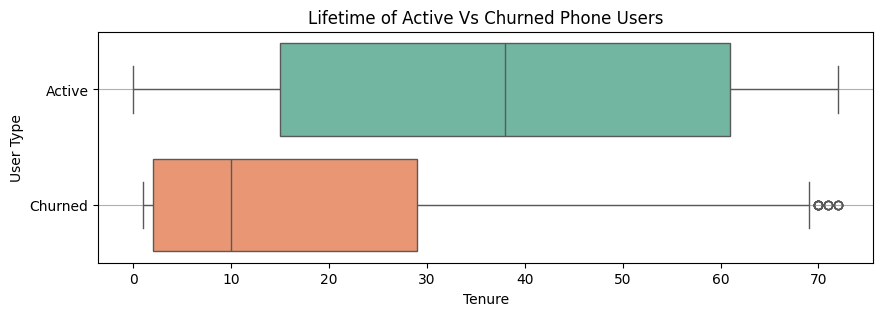

In [11]:
data = pd.DataFrame({
    'Active': active_phone_users['tenure'],
    'Churned': churned_phone_users['tenure']
})

# Create the box plot without melting the DataFrame
plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Active Vs Churned Phone Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [12]:
group_1 = active_phone_users['tenure']
group_2 = churned_phone_users['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(5838537.0), pvalue=np.float64(7.014719174462135e-185))

**Observation**: Current active phone users have stay with us much longer than churned phone users

## 2 Internet Service

### 2.1 Internet Vs Non-Internet (Active users)

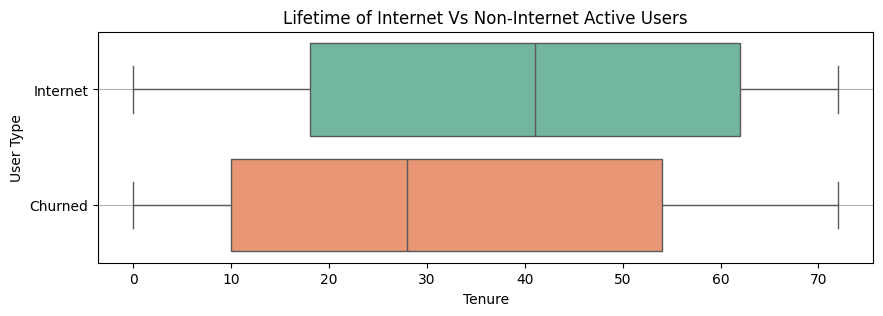

In [13]:
data = pd.DataFrame({
    'Internet': active_internet_users['tenure'],
    'Churned': active_users[~active_users.isin(active_internet_users)].dropna()['tenure']
})

# Create the box plot without melting the DataFrame
plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Internet Vs Non-Internet Active Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [14]:
group_1 = active_internet_users['tenure']
group_2 = churned_internet_users['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(4978462.0), pvalue=np.float64(2.0596236201332951e-203))

**Observation**: Active internet users have been with us longer than our non-Internet (phone only) users.

### 2.2 Internet Vs Non-Internet (Chunred users)

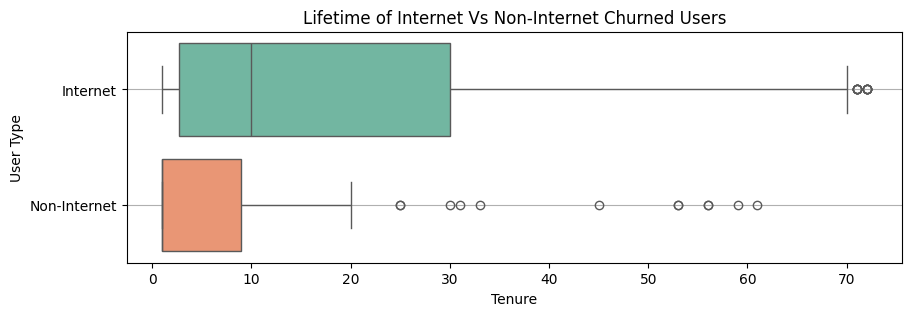

In [15]:
data = pd.DataFrame({
    'Internet': churned_internet_users['tenure'],
    'Non-Internet': churned_users[~churned_users.isin(churned_internet_users)].dropna()['tenure']
})

# Create the box plot without melting the DataFrame
plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Internet Vs Non-Internet Churned Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [16]:
group_1 = churned_internet_users['tenure']
group_2 = churned_users[~churned_users.isin(churned_internet_users)].dropna()['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(140108.5), pvalue=np.float64(1.4941675473595431e-13))

**Observations**: 
- Over half of the churned non-Internet (phone only) users churned in the first month of activation!
- Internet users churned later than non-internet users.

## 3 Phone Service

### 3.1 Phone Vs Non-Phone (Active)

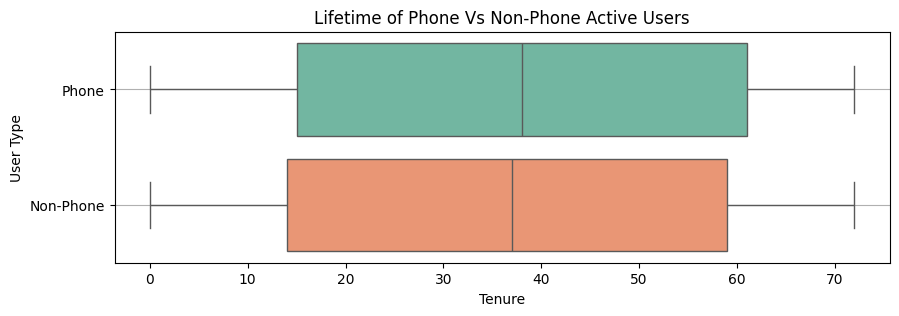

In [17]:
data = pd.DataFrame({
    'Phone': active_phone_users['tenure'],
    'Non-Phone': active_users[~active_users.isin(active_phone_users)].dropna()['tenure']
})

# Create the box plot without melting the DataFrame
plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Phone Vs Non-Phone Active Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [18]:
group_1 = active_phone_users['tenure']
group_2 = active_users[~active_users.isin(active_phone_users)].dropna()['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(1211621.5), pvalue=np.float64(0.5714985292231787))

**Observation**: The U-Test failed to reject the null hypothesis that the 2 groups come from the same distribution. Hence, Phone service for our active users has _not_ affected their tenure with us. 

### 3.2 Phone Vs Non-Phone (Churned users)

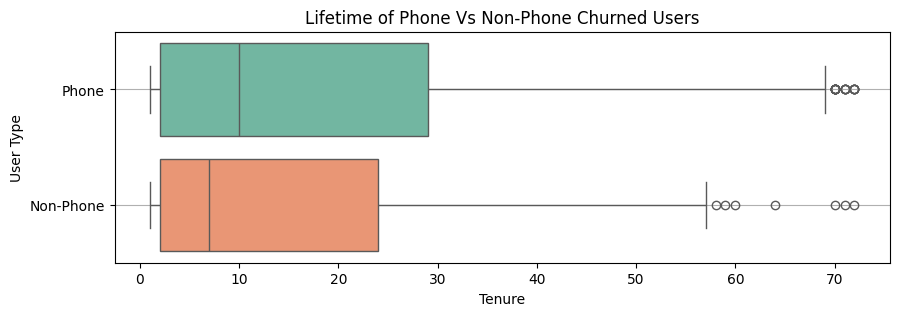

In [19]:
data = pd.DataFrame({
    'Phone': churned_phone_users['tenure'],
    'Non-Phone': churned_users[~churned_users.isin(churned_phone_users)].dropna()['tenure']
})

# Create the box plot without melting the DataFrame
plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Phone Vs Non-Phone Churned Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [20]:
group_1 = churned_phone_users['tenure']
group_2 = churned_users[~churned_users.isin(churned_phone_users)].dropna()['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(156387.5), pvalue=np.float64(0.07302903442813938))

**Observation**: Churned users with phone service stayed slightly longer with us than those without phone service.

## 4 Internet Vs Phone Vs Internet + Phone

### 4.1 Internet Vs Phone Vs Internet + Phone (Active Users)

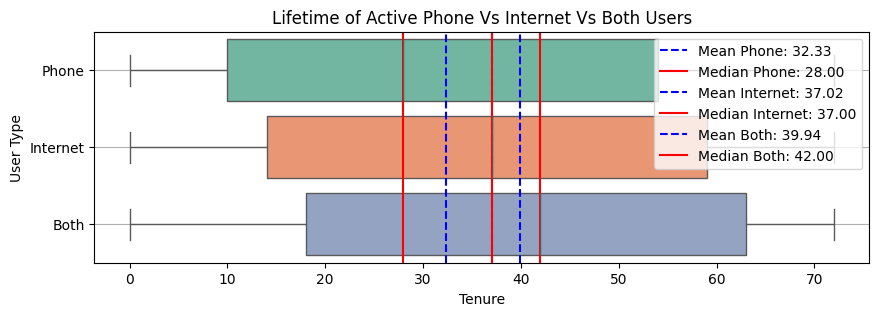

In [21]:
data = pd.DataFrame({
    'Phone': active_phone_users['tenure'][active_phone_users['InternetService'] == 'No'],
    'Internet': active_internet_users['tenure'][active_internet_users['PhoneService'] == 'No'],
    'Both': active_internet_users['tenure'][active_internet_users['PhoneService'] != 'No']
})

plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot

# Add mean and median lines
for col in data.columns:
    mean_value = data[col].mean()
    median_value = data[col].median()
    plt.axvline(mean_value, linestyle='--', color='blue', label=f'Mean {col}: {mean_value:.2f}')
    plt.axvline(median_value, linestyle='-', color='red', label=f'Median {col}: {median_value:.2f}')

    
plt.title("Lifetime of Active Phone Vs Internet Vs Both Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')

# Create a custom legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')


plt.show()

In [22]:
group_1 = active_phone_users['tenure'][active_phone_users['InternetService'] == 'No']
group_2 = active_internet_users['tenure'][active_internet_users['PhoneService'] == 'No']
group_3 = active_internet_users['tenure'][active_internet_users['PhoneService'] != 'No']

print("Phone Vs Both", stat_test(group_1, group_3))
print("Internet Vs Both", stat_test(group_2, group_3))
print("Internet Vs Phone", stat_test(group_2, group_1))

Performing U-Test ...
Phone Vs Both MannwhitneyuResult(statistic=np.float64(1874583.0), pvalue=np.float64(2.1275758216445415e-23))
Performing U-Test ...
Internet Vs Both MannwhitneyuResult(statistic=np.float64(771462.0), pvalue=np.float64(0.008275613433264115))
Performing U-Test ...
Internet Vs Phone MannwhitneyuResult(statistic=np.float64(403860.5), pvalue=np.float64(9.18692084676889e-05))


**Observation**: users who have both internet and phone services usually stay longer than those with just internet. And these users stay longer than users with just phone.

### 4.2 Internet Vs Phone Vs Internet + Phone (Churned Users)

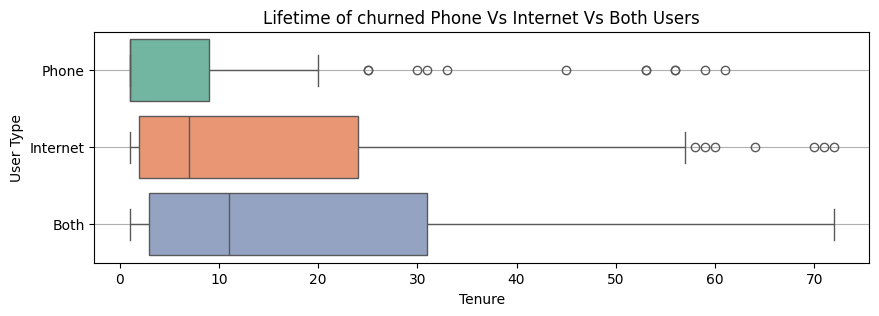

In [23]:
data = pd.DataFrame({
    'Phone': churned_phone_users['tenure'][churned_phone_users['InternetService'] == 'No'],
    'Internet': churned_internet_users['tenure'][churned_internet_users['PhoneService'] == 'No'],
    'Both': churned_internet_users['tenure'][churned_internet_users['PhoneService'] != 'No']
})

plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of churned Phone Vs Internet Vs Both Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [24]:
group_1 = churned_phone_users['tenure'][churned_phone_users['InternetService'] == 'No']
group_2 = churned_internet_users['tenure'][churned_internet_users['PhoneService'] == 'No']
group_3 = churned_internet_users['tenure'][churned_internet_users['PhoneService'] != 'No']

print("Phone Vs Both", stat_test(group_1, group_3))
print("Internet Vs Both", stat_test(group_2, group_3))
print("Internet Vs Phone", stat_test(group_2, group_1))

Performing U-Test ...
Phone Vs Both MannwhitneyuResult(statistic=np.float64(51819.0), pvalue=np.float64(4.972346366060637e-14))
Performing U-Test ...
Internet Vs Both MannwhitneyuResult(statistic=np.float64(119733.0), pvalue=np.float64(0.016047993911843323))
Performing U-Test ...
Internet Vs Phone MannwhitneyuResult(statistic=np.float64(12709.5), pvalue=np.float64(2.5834127922416013e-06))


**Observations**:
- users who had both internet and phone services stayed longer than those with just internet. And these users stay longer than users with just phone.
- Over 50% Churned users with just phone services churned within 1 month of activation

## 5 Fiber Optic Vs DSL

### 5.1 Fiber Optic Vs DSL(Active Users)

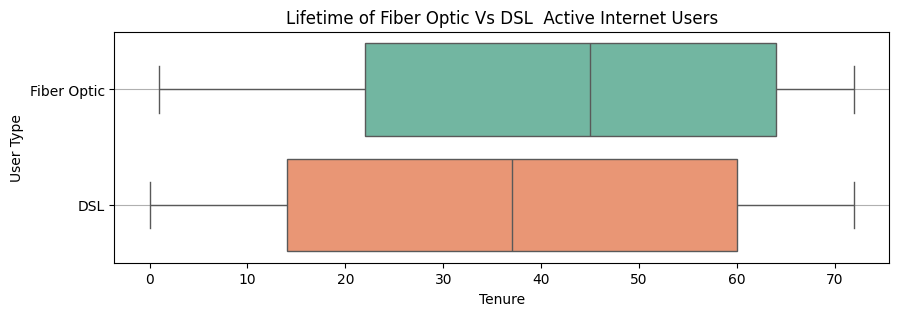

In [25]:
data = pd.DataFrame({
    'Fiber Optic': active_internet_users['tenure'][active_internet_users['InternetService'] == 'Fiber optic'],
    'DSL': active_internet_users['tenure'][active_internet_users['InternetService'] == 'DSL']
})

plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Fiber Optic Vs DSL  Active Internet Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [26]:
group_1 = active_internet_users['tenure'][active_internet_users['InternetService'] == 'Fiber optic']
group_2 = active_internet_users['tenure'][active_internet_users['InternetService'] == 'DSL']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(1971629.0), pvalue=np.float64(4.996295406980666e-10))

**Observation**: Our Fiber Optic users are older customers than our current DSL users.

### 5.2 Fiber Optic Vs DSL(Churned Users)

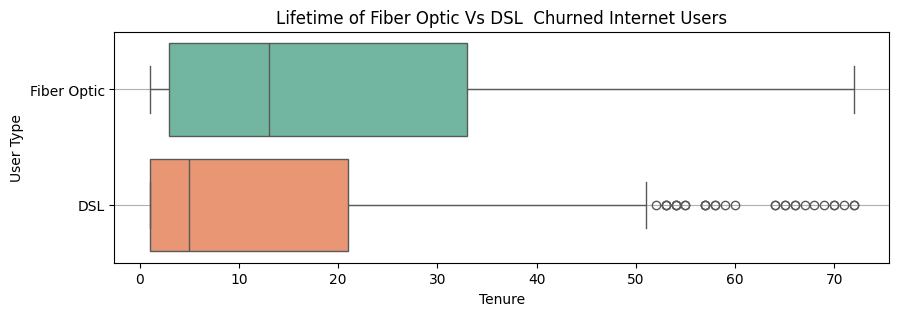

In [27]:
data = pd.DataFrame({
    'Fiber Optic': churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'Fiber optic'],
    'DSL': churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'DSL']
})

plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Fiber Optic Vs DSL  Churned Internet Users")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [28]:
group_1 = churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'Fiber optic']
group_2 = churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'DSL']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(361195.0), pvalue=np.float64(8.58291191552375e-12))

**Observation**: Internet Users with a Fiber Optic Connection Stayed with us longer than DSL users.

# 6 Tech Support

### 6.1 Tech Support (Active Users)

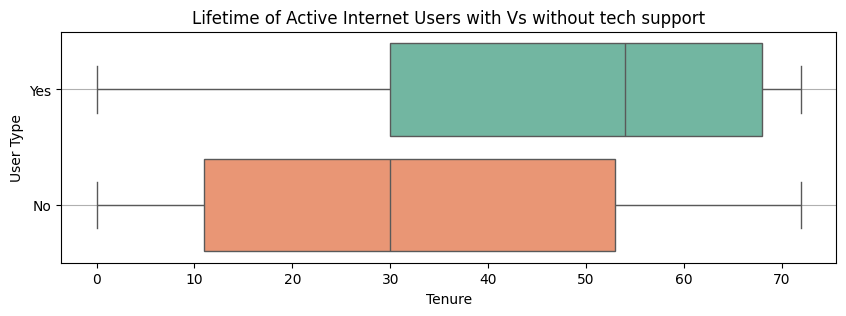

In [29]:
data = pd.DataFrame({
    'Yes': active_internet_users['tenure'][active_internet_users['TechSupport'] == 'Yes'],
    'No': active_internet_users['tenure'][active_internet_users['TechSupport'] == 'No']
})

plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Active Internet Users with Vs without tech support")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [30]:
group_1 = active_internet_users['tenure'][active_internet_users['TechSupport'] == 'Yes']
group_2 = active_internet_users['tenure'][active_internet_users['TechSupport'] == 'No']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(2416783.5), pvalue=np.float64(7.312385961969061e-88))

**Observations**: 
- Over half of our current active internet users who have tech support have been with us for over 4 years.

### 6.2 Tech Support (Churned Users)

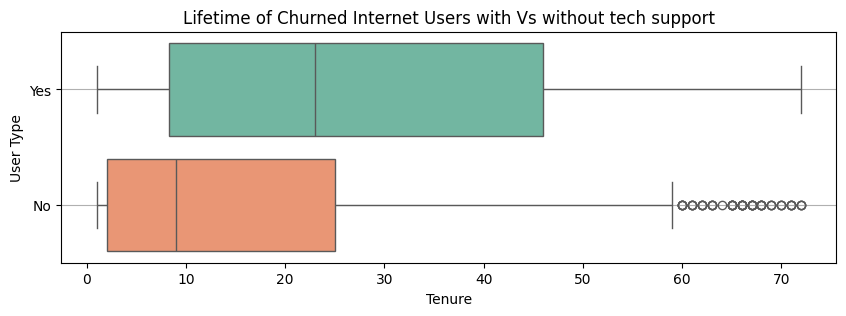

In [31]:
data = pd.DataFrame({
    'Yes': churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'Yes'],
    'No': churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'No']
})

plt.figure(figsize=(10, 3))
sns.boxplot(data=data, orient='h', palette='Set2')  # Set orient='h' for horizontal box plot
plt.title("Lifetime of Churned Internet Users with Vs without tech support")
plt.xlabel("Tenure")
plt.ylabel("User Type")
plt.grid(axis='y')
plt.show()

In [32]:
group_1 = churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'Yes']
group_2 = churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'No']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=np.float64(304133.5), pvalue=np.float64(3.7944674838206225e-23))

**Observations**:Users who did not have tech support churned earlier than those internet users who did.

# 7 Observation Summary 

Here is a compilation of all the observations made. Note this is not an exhaustive list.
- 76% of our churned Phone users had a Fiber Optic internet service
- Over 30% of our current phone users have no internet plan. 
- Current active internet users have stay with us much longer than churned users
- Current active phone users have stay with us much longer than churned phone users
- Active internet users have been with us longer than our non-Internet (phone only) users
- Over half of the churned non-Internet (phone only) users churned in the first month of activation!
- Internet users churned later than non-internet users.
- Phone service for our active users has _not_ affected their tenure with us. 
- Churned users with phone service stayed slightly longer with us than those without phone service.
- Users who have both internet and phone services usually stay longer than those with just internet. And these users stay longer than users with just phone.
- Users who had both internet and phone services stayed longer than those with just internet. And these users stay longer than users with just phone.
- Over 50% Churned users with just phone services churned within 1 month of activation
- Our Fiber Optic users are older customers than our current DSL users.
- Internet Users with a Fiber Optic Connection Stayed with us longer than DSL users.
- Over half of our current active internet users who have tech support have been with us for over 4 years.
- Users who did not have tech support churned earlier than those internet users who did.

# 8 What Can we do to improve Telco?

Now that we have some facts. It is important to devise solutions to problems that may exist. I'll state solutions based on 4 facts in (7)

**FACT 1: Internet + phone users are usually active longer than exclusive internet or exclusive phone users**

Proposal: When a user signs up for a phone service, entice them with an additional internet package with reduced prices. 

<img src="../pics/get_internet.png" width=500>

**FACT 2: Over 50% of our exclusive phone customers churned within 1 month of activation.**

Proposal*: Improve our phone service policy and cernter around the customer, not Telco. However, Since over half of our current exclusive phone active users have been with us for over 2 years, we have already been improving in that regard.

<img src="../pics/phone_features.png" width=500>

**FACT 3: Fiber Optic Internet users stay longer with us than DSL users**

Proposal: DSL and Fiber Optic internet Service have their advantages. Fiber Optic is Faster, while DSL is available in most areas and is more affordable. Customers need an internet service that suits their needs like location, bandwidth usage, price. We could offer FO internet packages with discounted prices for larger businesses (or larger bandwidth-consuming individuals).  

<img src="../pics/FOVsDSL.png" width=500>

**FACT 4: Users with Technical Support stay with us much longer than users without.**

Proposal: Bundle Technical support with Internet Subscription (free at least for a limited time if expensive) 

<img src="../pics/tech_support.png" width=500>

# 9 Machine Learning?

Before we think about machine learning, we need to ensure there is a problem to solve in the first place. Given transaction history by users with our competitors, We can predict when they are likely to churn. Either regressed in terms of "number of months till churn" or create a binary classifier which answers "Will churn in X months". I am not doing that in this notebook.

# 10 Appendix

## 10.1 Hypothesis Testing

For the comparison of 2 or more groups done throughout this notebook, we cannot say the tenure of one is greater/less than the others without conducting a test of significance. For 2 comparing 2 groups, I defined the `stat_test` function.


### 10.1.1 For 2 groups

I wanted to conduct the t-Test which assumes data is:
- Normally distributed: Tested using the Spairo Wilk test
- Homoscendastic: The 2 groups have equal variance is tested with the Levene Test

If the normality assumption is violated, I have 2 options:
- Convert the data into a normal distribution. How?
    - Try taking the log of data
    - Box Cox
- perform the Mann Whiteney U-Test (which assumes data is i.i.d)

If neither method works to convert data into a normal distribution, then we simply perform the U-Test.

### 10.1.2 For more than 2 groups

I wanted to conduct ANOVA which assumes the normal distribution and equal variances. However, it is usually the case that the normality assumption is violated. We could use Kruskal's H-Test, but the null hypothesis is weak. 

$$
H_0: \text{The median of all groups is equal}
$$

If $H_0$ is rejected, we have no idea which groups have different medians. Hence, I perform the pairwise Mann Whiteney U test in case the assumptions for ANOVA fail. 